In [16]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from imblearn.over_sampling import RandomOverSampler, SMOTE
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow import keras

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from tqdm import tqdm

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *
from sklearn.pipeline import Pipeline

from tensorflow.keras import Input, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, MaxPool2D

from mlxtend import evaluate, plotting
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [17]:
dataSet = pd.read_csv("hmnist_28_28_RGB.csv")

Label = dataSet["label"]
Data = dataSet.drop(columns=["label"]) 


oversample = SMOTE()
Data,Label  = oversample.fit_resample(Data,Label)


Data = np.array(Data).reshape(-1,28,28,3)
print('Shape of Data :',Data.shape)

Shape of Data : (46935, 28, 28, 3)


In [18]:
classes = {4: ('nv', ' melanocytic nevi'),
           6: ('mel', 'melanoma'),
           2 :('bkl', 'benign keratosis-like lesions'), 
           1:('bcc' , ' basal cell carcinoma'),
           5: ('vasc', ' pyogenic granulomas and hemorrhage'),
           0: ('akiec', 'Actinic keratoses and intraepithelial carcinomae'),
           3: ('df', 'dermatofibroma')}

In [19]:
X_train , X_test , y_train , y_test = train_test_split(Data , Label , test_size = 0.3 , random_state = 42, stratify=Label)

In [20]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [21]:
datagen = ImageDataGenerator(rescale=(1./255)
                             ,rotation_range=10
                             ,zoom_range = 0.1
                             ,width_shift_range=0.1
                             ,height_shift_range=0.1
                             ,horizontal_flip = True
                             ,fill_mode='nearest')
testgen = ImageDataGenerator(rescale=(1./255))

In [22]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy'
                                            , patience = 2
                                            , verbose=1
                                            ,factor=0.5
                                            , min_lr=0.00001)

saved_model = 'manual_CNN.hdf5'

checkpointer = ModelCheckpoint(filepath = saved_model, save_best_only = True, save_weights_only = True)

In [23]:
def My_Model():
    input_ = keras.layers.Input(shape = [28,28,3])
    x = keras.layers.Conv2D(32 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(input_)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
    x = keras.layers.Conv2D(64 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
    x = keras.layers.Conv2D(128 , (3,3) , activation='relu',padding='same' , kernel_initializer='he_normal')(x)
    x = keras.layers.MaxPooling2D()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.Conv2D(256 , (3,3) , activation='relu' ,padding='same', kernel_initializer='he_normal')(x)
    x = keras.layers.MaxPooling2D()(x)
    flatten  = keras.layers.Flatten()(x)
    classifier = keras.layers.Dropout(rate = 0.2)(flatten)
    classifier = keras.layers.Dense(units = 256 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
    classifier = keras.layers.BatchNormalization()(classifier)
    classifier = keras.layers.Dense(units = 128 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
    classifier = keras.layers.BatchNormalization()(classifier)
    classifier = keras.layers.Dense(units = 64 , activation = 'relu' , kernel_initializer = 'he_normal')(classifier)
    classifier = keras.layers.BatchNormalization()(classifier) 
    classifier = keras.layers.Dense(units = 32 , activation = 'relu' , kernel_initializer = 'he_normal' , kernel_regularizer=keras.regularizers.L1L2())(classifier)
    classifier = keras.layers.BatchNormalization()(classifier) 
    classifier = keras.layers.Dense(units = 7 , activation='softmax' ,kernel_initializer="glorot_uniform" , name = 'classifier')(classifier)

    return keras.models.Model(inputs = input_  ,outputs =  classifier  )

In [24]:
model = My_Model()

In [25]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 3)]       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 14, 14, 64)        3692

In [28]:
model.compile(optimizer='adam' , loss = keras.losses.CategoricalCrossentropy() ,metrics = ['accuracy'])

In [29]:
history = model.fit(X_train ,
                    y_train ,
                    epochs=10 ,
                    batch_size=128,
                    validation_data=(X_test , y_test) ,
                    callbacks=[learning_rate_reduction, checkpointer])

Epoch 1/10
257/257 [==============================] - 38s 144ms/step - loss: 0.9502 - accuracy: 0.6563 - val_loss: 0.7701 - val_accuracy: 0.7428 - lr: 0.0010
Epoch 2/10
257/257 [==============================] - 36s 142ms/step - loss: 0.4308 - accuracy: 0.8472 - val_loss: 0.4835 - val_accuracy: 0.8165 - lr: 0.0010
Epoch 3/10
257/257 [==============================] - 36s 141ms/step - loss: 0.2919 - accuracy: 0.8939 - val_loss: 0.4840 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 4/10
257/257 [==============================] - 36s 141ms/step - loss: 0.2091 - accuracy: 0.9269 - val_loss: 0.8599 - val_accuracy: 0.7567 - lr: 0.0010
Epoch 5/10
257/257 [==============================] - 36s 141ms/step - loss: 0.1702 - accuracy: 0.9399 - val_loss: 0.4341 - val_accuracy: 0.8624 - lr: 0.0010
Epoch 6/10
257/257 [==============================] - 36s 141ms/step - loss: 0.1434 - accuracy: 0.9494 - val_loss: 0.3609 - val_accuracy: 0.8717 - lr: 0.0010
Epoch 7/10
257/257 [==============================] 

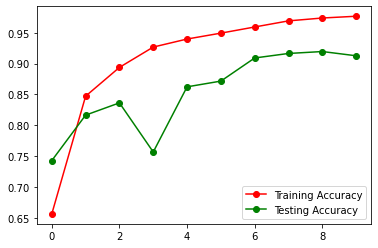

In [30]:
plt.plot(history.history["accuracy"] , 'ro-' , label = "Training Accuracy")
plt.plot(history.history["val_accuracy"] , 'go-' , label = "Testing Accuracy")
plt.legend()
plt.show()

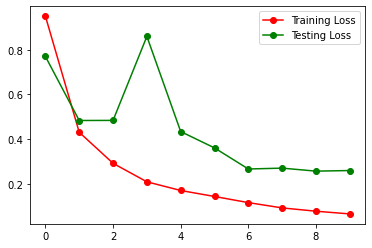

In [31]:
plt.plot(history.history["loss"] , 'ro-' , label = "Training Loss")
plt.plot(history.history["val_loss"] , 'go-' , label = "Testing Loss")
plt.legend()
plt.show()

In [32]:
y_pred  = model.predict(X_test).round()

In [33]:
target_names = [f"{classes[i]}" for i in range(7)]
print(classification_report(y_test , y_pred , target_names =target_names ))

                                                               precision    recall  f1-score   support

('akiec', 'Actinic keratoses and intraepithelial carcinomae')       0.96      0.97      0.96      2011
                             ('bcc', ' basal cell carcinoma')       0.99      0.90      0.94      2011
                     ('bkl', 'benign keratosis-like lesions')       0.94      0.82      0.87      2012
                                     ('df', 'dermatofibroma')       0.98      0.99      0.99      2012
                                  ('nv', ' melanocytic nevi')       0.73      0.87      0.80      2012
              ('vasc', ' pyogenic granulomas and hemorrhage')       0.98      1.00      0.99      2011
                                          ('mel', 'melanoma')       0.89      0.82      0.85      2012

                                                    micro avg       0.92      0.91      0.91     14081
                                                    macro avg       0.9

C:\Users\Tau\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 720x720 with 0 Axes>

<AxesSubplot:>

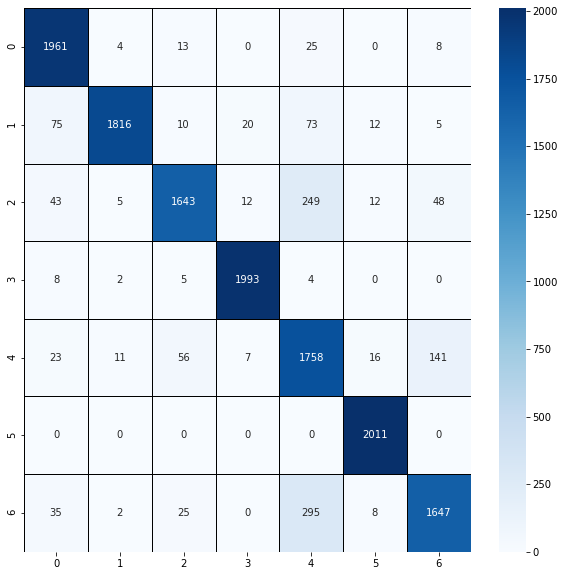

In [34]:
cm = confusion_matrix(y_test.argmax(axis = 1) , y_pred.argmax(axis = 1))
cm = pd.DataFrame(cm , index = [i for i in range(7)] , columns = [i for i in range(7)])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('ham10k_cnn.tflite', 'wb') as f:
  f.write(tflite_model)